### Imports and reading in the dataset

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as stats
import seaborn as sns

%matplotlib inline


In [150]:
current_dir = os.getcwd()
filename = '13 million Duolingo student learning traces.csv'
filepath = os.path.normpath(os.path.join(current_dir, '../data/raw', filename))
chunk_size = 10000
chunks = []


for chunk in pd.read_csv(filepath, chunksize=chunk_size):
    chunk.drop_duplicates(inplace=True)
    chunk.dropna(inplace=True)
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

# Take a sample of dataframe 
# df = df.sample(2000000)


def out_filepath(filename):
    return os.path.normpath(os.path.join(current_dir, '../reports/EDA', filename))

### Columns explained
p_recall - session_correct/session_seen  
timestamp - UNIX timestamp of the current lesson  
delta - time (in seconds) since the last lesson that included this word  
user_id - student user ID  
learning_language - language being learned  
ui_language - user interface language (presumably native to the student)  
lexeme_id - system ID for the lexeme tag (i.e., word)  
lexeme_string - lexeme tag for word  
history_seen - total times user has seen the word prior to this lesson  
history_correct - total times user has been correct for the word prior to this lesson  
session_seen - times the user saw the word during this lesson  
session_correct - times the user got the word correct during this lesson  

In [151]:
df.head()
df.head().to_html('dataset_head.html')

### Data Preparation

In [152]:
df.reset_index(inplace=True, drop=True)

In [153]:
# Check the types
df.dtypes

p_recall             float64
timestamp              int64
delta                  int64
user_id               object
learning_language     object
ui_language           object
lexeme_id             object
lexeme_string         object
history_seen           int64
history_correct        int64
session_seen           int64
session_correct        int64
dtype: object

In [154]:
# Check for na
nan_count = df.isna().sum().sum()
print(f'There are {nan_count} missing values in the dataset')

There are 0 missing values in the dataset


In [155]:
# Check for duplicates
duplicates_count = df.duplicated().sum().sum()
df.drop_duplicates(inplace=True)
print(f'There were {duplicates_count} missing values in the dataset')

There were 0 missing values in the dataset


In [156]:
# New column ui language - learning language 
df['lang_combination'] = df['ui_language'] + '-' + df['learning_language']

# New column - historical probability of recall  
df['h_recall'] = df['history_correct']/df['history_seen']

# New columns - words and their length
df['word'] = df['lexeme_string'].str.split("/").str[0]
df['word_len'] = df['word'].apply(lambda x: len(x))

In [157]:
# Retrieve numeric columns 
df_numeric = df.select_dtypes(np.number)
features = df_numeric.columns.tolist()

# Retrieve object columns  
df_obj = df.select_dtypes(include='object')

In [158]:
# Describe numerical columns 
# num_desc = df.drop(['h_recall'], axis=1)
df_numeric_describe = df_numeric.describe().map(lambda x: f"{x:0.3f}")
df_numeric_describe.to_html('df_numeric_describe.html')
# num_desc

In [117]:
print(f"""
P_RECALL (proportion of correct answers to total answers in one session): the mean is {num_desc['p_recall'].loc['mean']} , the median is {num_desc['p_recall'].loc['50%']}.
More than 75% users can answer all questions correctly in one session.

DELTA: on average there are {round(float(num_desc['delta'].loc['mean'])/(60*60*60),2)} days between sessions, the median is {round(float(num_desc['delta'].loc['50%'])/(60*60*60),2)} day. 
Max value is {round(float(num_desc['delta'].loc['max'])/(60*60*60),2)} days which suggests very high outliers. 
75% users have less than {round(float(num_desc['delta'].loc['75%'])/(60*60*60),2)} days between sessions.

HISTORY SEEN: most users review the word {num_desc['history_seen'].loc['50%']} times seen prior to this session,the max is very high {num_desc['history_seen'].loc['max']}

HISTORY CORRECT: most users are historically {num_desc['history_correct'].loc['50%']} times correct, standard deviation {num_desc['history_correct'].loc['std']}. 

SESSION SEEN: the word is usually seen {num_desc['session_seen'].loc['50%']} time during session, on average {num_desc['session_seen'].loc['mean']}. 

SESSION CORRECT: mean {num_desc['session_correct'].loc['mean']}, median {num_desc['session_correct'].loc['50%']}
""")

NameError: name 'num_desc' is not defined

In [118]:
# Describe categorical columns
obj_desc = df.describe(include=['O'])
obj_desc
obj_desc.to_html('dataset_obj_description.html')

In [119]:
print(f"""There are {obj_desc['user_id'].loc['unique']} unique users, learning 6 languages. The most popular language is {obj_desc['learning_language'].loc['top']}
with {round(100*(int(obj_desc['learning_language'].loc['freq'])/int(obj_desc['learning_language'].loc['count'])),2)}% of total observations. The most popular language combination is {obj_desc['lang_combination'].loc['top']}
with {round(100*(int(obj_desc['lang_combination'].loc['freq'])/int(obj_desc['lang_combination'].loc['count'])),2)}% of total observations""")

There are 115222 unique users, learning 6 languages. The most popular language is en
with 39.01% of total observations. The most popular language combination is es-en
with 28.33% of total observations


### Delete outliers

In [120]:
a

NameError: name 'a' is not defined

In [121]:
users_with_outliers = ['u:FO', 'u:vYt', 'u:rcI', 'u:tTE', 'u:mgu', 'u:uYR', 'u:kc1', 'u:mSj', 'u:o8z', 'u:npU', 'u:noU', 'u:ltZ',
                       'u:cTQ', 'u:qSu', 'u:bpC', 'u:KX', 'u:ise', 'u:jaD', 'u:dCn', 'u:g3Q']

a = df.loc[df['user_id'].isin(users_with_outliers)]
a.groupby(['user_id'])['delta_day'].mean()

KeyError: 'Column not found: delta_day'

In [159]:
# df['delta_day'] = df['delta']/(60*60*24)
cols_to_check = ['delta', 'history_seen', 'history_correct', 'session_seen', 'session_correct']

for col in cols_to_check:
    high = df[col].quantile(0.999)
    outliers = df[df[col] > high]
    print(f"\nTop 0.1% values in {col}:")
    print('such values',len(outliers))
    print('users with such values:', len(outliers['user_id'].unique()))
    print('percent of users', len(outliers['user_id'].unique())/len(outliers)*100)
    print('mean interval', outliers['delta_day'].mean())
    print(outliers[[col, 'session_seen', 'session_correct', 'history_seen', 'history_correct', 'user_id', 'word', 'delta_day']][:20])
    print(outliers['user_id'].unique()[:20])


Top 0.1% values in delta:
such values 12855
users with such values: 880
percent of users 6.845585375340335


KeyError: 'delta_day'

In [123]:
# Z-score removal -> removed 12% of data
threshold_z = 3
z = np.abs(stats.zscore(df_numeric))   
df = df[(z < threshold_z).all(axis=1)]


print("Original DataFrame Shape:", df_numeric.shape[0])
print("DataFrame Shape after Removing Outliers:", df.shape[0])
print('Rows removed', df_numeric.shape[0]- df.shape[0])


df_numeric = df.select_dtypes(np.number)
print('Z after removal', np.abs(stats.zscore(df_numeric)).max())  


Original DataFrame Shape: 12854145
DataFrame Shape after Removing Outliers: 11198780
Rows removed 1655365
Z after removal p_recall            6.600340
timestamp           1.762490
delta               6.969808
history_seen       12.560923
history_correct    11.998637
session_seen        3.120066
session_correct     3.455761
h_recall            3.336461
word_len            2.836654
dtype: float64


In [ ]:
# 99th percentile removal

cols_to_trim = ['delta', 'history_seen', 'history_correct']

for col in cols_to_trim:
    upper_bound = df[col].quantile(0.99)
    df_trimmed = df[df[col] <= upper_bound]


print(f"Original rows: {len(df)}")
print(f"Trimmed rows:  {len(df_trimmed)}")
print(f"Rows removed:  {len(df) - len(df_trimmed)}")

df = df_trimmed

In [125]:
# Describe after removal 
num_desc = df.describe().map(lambda x: f"{x:0.3f}")

In [126]:
print(f"""
P_RECALL (proportion of correct answers to total answers in one session): the mean is {num_desc['p_recall'].loc['mean']}, the median is {num_desc['p_recall'].loc['50%']}.
More than 75% users can answer all questions correctly in one session.

DELTA: the mean is {round(float(num_desc['delta'].loc['mean'])/(60*60*60),2)} days between sessions, the median is {round(float(num_desc['delta'].loc['50%'])/(60*60*60),2)} days. 
Max value is {round(float(num_desc['delta'].loc['max'])/(60*60*60),2)} days, 
75% users have less than {round(float(num_desc['delta'].loc['75%'])/(60*60*60),2)} between sessions.

HISTORY SEEN: median is {num_desc['history_seen'].loc['50%']} times seen prior to this session,the max is high {num_desc['history_seen'].loc['max']}

HISTORY CORRECT: median is {num_desc['history_correct'].loc['50%']} times correct, standard deviation {num_desc['history_correct'].loc['std']}. 

SESSION SEEN: usually around {num_desc['session_seen'].loc['50%']} time seen during session, mean {num_desc['session_seen'].loc['mean']}. 

SESSION CORRECT: mean {num_desc['session_correct'].loc['mean']}, median {num_desc['session_correct'].loc['50%']}""")


P_RECALL (proportion of correct answers to total answers in one session): the mean is 0.966, the median is 1.000.
More than 75% users can answer all questions correctly in one session.

DELTA: the mean is 2.15 days between sessions, the median is 0.33 days. 
Max value is 34.58 days, 
75% users have less than 1.91 between sessions.

HISTORY SEEN: median is 6.000 times seen prior to this session,the max is high 301.000

HISTORY CORRECT: median is 6.000 times correct, standard deviation 18.706. 

SESSION SEEN: usually around 1.000 time seen during session, mean 1.735. 

SESSION CORRECT: mean 1.641, median 1.000


### Frequency of learning languages 

In [ ]:
df['lang_combination'] = df['ui_language']+'-'+df['learning_language']

In [ ]:
lang_combinations = df.groupby(['lang_combination']).size().to_frame('count').reset_index()
lang_combinations['% obs'] = (lang_combinations['count']/lang_combinations['count'].sum())*100
lang_combinations.sort_values(by='count', inplace=True)
# print(lang_combinations)

target_langs = df.groupby(['learning_language']).size().to_frame('count').reset_index()
target_langs['% obs'] = (target_langs['count']/target_langs['count'].sum())*100
target_langs.sort_values(by='count', inplace=True)
# print(target_langs)

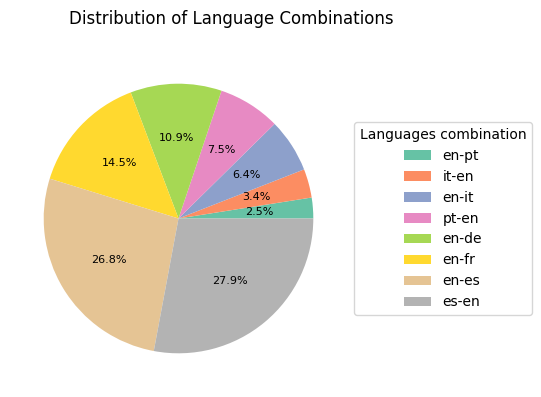

In [129]:
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))
# colors = sns.color_palette('Set2')[0:8]

# wedges1, texts1, autotexts1 = ax1.pie(lang_combinations['count'], colors=colors, autopct='%1.1f%%')
# wedges2, texts2, autotexts2 =  ax2.pie(target_langs['count'], colors=colors, autopct='%1.1f%%')
# ax1.legend(wedges1, lang_combinations['lang_combination'], title="Languages combination", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
# ax2.legend(wedges2, target_langs['learning_language'], title="Learning Languages", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))


# plt.setp(autotexts1, size=8)
# plt.setp(autotexts2, size=8)

# fig.suptitle('Distributions of languages')
# plt.tight_layout()


fig, ax1 = plt.subplots(figsize=(6, 4))  # Single axis instead of two
colors = sns.color_palette('Set2')[0:8]

wedges1, texts1, autotexts1 = ax1.pie(
    lang_combinations['count'],
    colors=colors,
    autopct='%1.1f%%'
)

ax1.legend(
    wedges1,
    lang_combinations['lang_combination'],
    title="Languages combination",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.setp(autotexts1, size=8)

fig.suptitle('Distribution of Language Combinations', x=0.5)
plt.tight_layout()

plt.savefig(out_filepath('languages_distribution.png'))
plt.show()


### Languages combination 
Language combination is in format: UI language - learning language. The most popular is Spanish-English, then English-Spanish, which sum up to > 50% of total observations. The least popular is English-Portugese. In the dataset, only English speakers learn 5 different European languages, while non-English speakers only learn English.   


### Learning languages
The most popular learning language is English, followed by Spanish, summing up to > 60% of total observations. The least popualar is Portugese. 


### Sessions accuracy

In [130]:
sessions_size = df.groupby(["session_seen", "session_correct"]).size().reset_index(name='counts')
sessions_size

,session_seen,session_correct,counts
0,1,1,6389300
1,2,1,395229
2,2,2,2085065
3,3,1,24902
4,3,2,259024
5,3,3,1003059
6,4,1,1438
7,4,2,23253
8,4,3,155256
9,4,4,445585


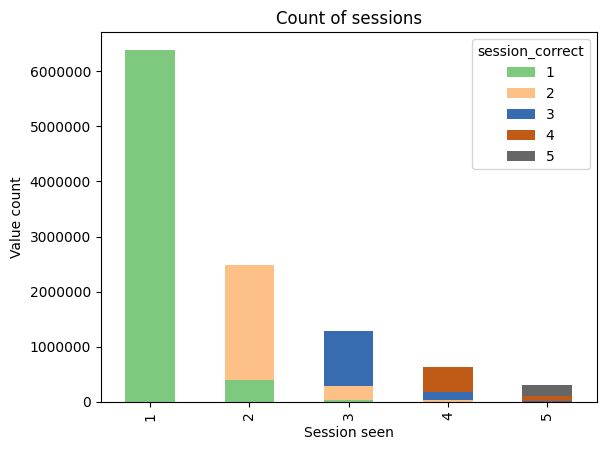

In [148]:
sessions_size_filtered = sessions_size[sessions_size['session_seen'] < 10]


pivot_sess = sessions_size_filtered.pivot(index='session_seen', 
                                 columns='session_correct', 
                                 values='counts')



ax = pivot_sess.plot(kind='bar', stacked=True, colormap='Accent')

ax.set_ylabel('Value count')
ax.set_xlabel('Session seen')
ax.set_title('Count of sessions')
# ax.set_xticks(rotation='horizontal')

ax.ticklabel_format(style='plain', axis='y')

plt.savefig(out_filepath('sessions_count.png'), bbox_inches='tight')
plt.show()


In the dataset without outliers, when the word is seen 1 time and guessed correctly, it seems to never appear again during the session, so there is a 100% accuracy. The word seen 1 time is a majority of occurrences. 
After deleting outliers, 5 is the maximum number of possible times, the word can be seen during session


### Datetime analysis

In [132]:
from datetime import datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop(columns=['timestamp'], inplace=True)
df['weekday'] = df['datetime'].dt.day_name()
df['date'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour
print(f'Range of dates: from {df['datetime'].min()} to {df['datetime'].max()}')
print(f'The first day of observation is {(df['datetime'].min().to_pydatetime().strftime('%A'))}, the last is {(df['datetime'].max().to_pydatetime().strftime('%A'))}')


Range of dates: from 2013-02-28 20:07:12 to 2013-03-12 16:14:57
The first day of observation is Thursday, the last is Tuesday


In [133]:
# Take only one week
start_date = pd.to_datetime('2013-03-01').date()
end_date = pd.to_datetime('2013-03-07').date()

df_dates = df[df['date'].between(start_date, end_date)]
print(f'Range of dates: from {df_dates['datetime'].min()} to {df_dates['datetime'].max()}')
print(f'The first day of observation is {(df_dates['datetime'].min().to_pydatetime().strftime('%A'))}, the last is {(df_dates['datetime'].max().to_pydatetime().strftime('%A'))}')


Range of dates: from 2013-03-01 00:00:00 to 2013-03-07 23:59:59
The first day of observation is Friday, the last is Thursday


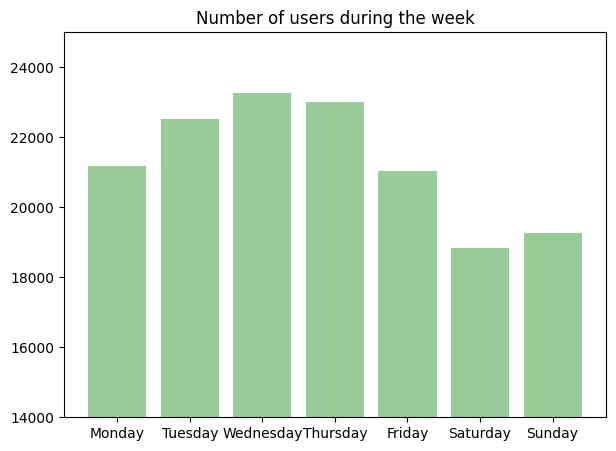

In [134]:
df_weekdays = df_dates[['weekday', 'user_id']].groupby('weekday').nunique().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']).reset_index()
fig, ax = plt.subplots(figsize = (7, 5))
ax.bar(df_weekdays['weekday'], df_weekdays['user_id'], color='g', alpha=0.4)
ax.set(ylim=[14000, 25000])
plt.title('Number of users during the week')
plt.savefig(out_filepath('weekly_users.png'))

The day with the most users is on Wednesday, then there is a gradual decline until the lowest number of users is reached on Saturday. After Saturday, the number of users rise again. The weekends, on the contrary to the working days have overall the lowest app engagement

### Hour when there are the most users

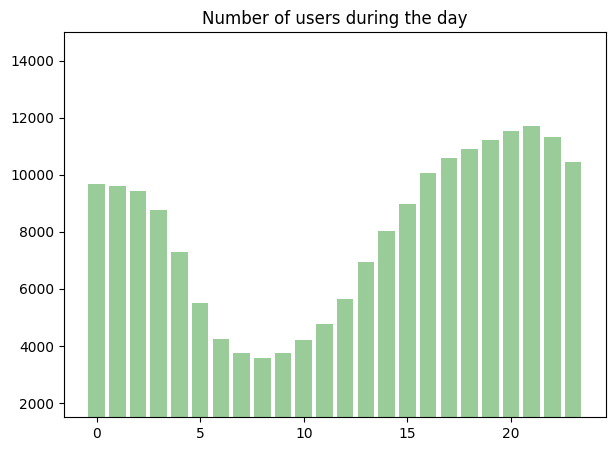

In [135]:
df_hours = df_dates[['hour', 'user_id']].groupby('hour').nunique().reset_index()

fig, ax = plt.subplots(figsize = (7, 5))
ax.bar(df_hours['hour'], df_hours['user_id'], color='g', alpha=0.4)
ax.set(ylim=[1500, 15000])
plt.title('Number of users during the day')
plt.savefig(out_filepath('day_users.png'))
plt.show()


The peak in the users activity is during the evening hours, reaching the peak at 9pm. After that, the number of users gradually decreases, with the minimum at 8am. The sharpest decrese happens between 3 and 4 am

### Visualize distributions of numeric variables - boxplots


In [136]:
df

,p_recall,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,lang_combination,h_recall,word,word_len,datetime,weekday,date,hour
7,1.00,444407,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,bajo/bajo<pr>,3,3,1,1,en-es,1.000000,bajo,4,2013-02-28 20:07:12,Thursday,2013-02-28,20
9,0.75,5963,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,die/die<det><def><f><sg><nom>,6,5,4,3,en-de,0.833333,die,3,2013-02-28 20:07:24,Thursday,2013-02-28,20
11,0.80,5963,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,frau/frau<n><f><sg><nom>,8,6,5,4,en-de,0.750000,frau,4,2013-02-28 20:07:24,Thursday,2013-02-28,20
12,0.80,5963,u:FO,de,en,84920990d78044db53c1b012f5bf9ab5,das/das<det><def><nt><sg><nom>,5,5,5,4,en-de,1.000000,das,3,2013-02-28 20:07:24,Thursday,2013-02-28,20
13,1.00,5963,u:FO,de,en,56429751fdaedb6e491f4795c770f5a4,der/der<det><def><m><sg><nom>,5,4,5,5,en-de,0.800000,der,3,2013-02-28 20:07:24,Thursday,2013-02-28,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854139,1.00,368,u:i5D8,en,it,928787744a962cd4ec55c1b22cedc913,eats/eat<vblex><pri><p3><sg>,5,4,4,4,it-en,0.800000,eats,4,2013-03-12 16:14:57,Tuesday,2013-03-12,16
12854140,0.80,368,u:i5D8,en,it,d5efc552aaea3109eb5388aa1ec8673d,the/the<det><def><sp>,6,4,5,4,it-en,0.666667,the,3,2013-03-12 16:14:57,Tuesday,2013-03-12,16
12854141,0.80,368,u:i5D8,en,it,a826c47947d68549fa81e19cafa57ba0,eat/eat<vblex><pres>,4,4,5,4,it-en,1.000000,eat,3,2013-03-12 16:14:57,Tuesday,2013-03-12,16
12854142,1.00,368,u:i5D8,en,it,5e29d77697d23070a1fb92eb6c90e9b6,bread/bread<n><sg>,4,4,4,4,it-en,1.000000,bread,5,2013-03-12 16:14:57,Tuesday,2013-03-12,16


In [161]:
# df['word'] = df['lexeme_string'].str.split("/").str[0]
df['word_len'] = df['word'].apply(lambda x: len(x))

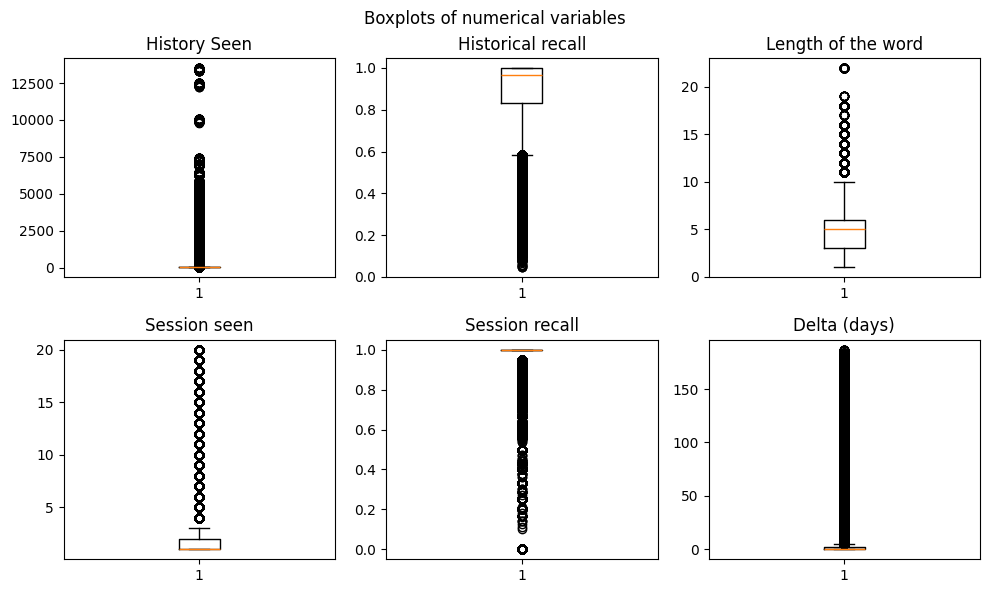

In [38]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

axs[0,0].boxplot(df['history_seen'])
axs[0,0].set_title('History Seen')

axs[1,0].boxplot(df['session_seen'])
axs[1,0].set_title('Session seen')

axs[0,1].boxplot(df['h_recall'])
axs[0,1].set_title('Historical recall')

axs[1,1].boxplot(df['p_recall'])
axs[1,1].set_title('Session recall')

axs[0,2].boxplot(df['word_len'])
axs[0,2].set_title('Length of the word')

axs[1,2].boxplot(df['delta']/(60*60*60))
axs[1,2].set_title('Delta (days)')

plt.ticklabel_format(style='plain', axis='y')
fig.suptitle('Boxplots of numerical variables')
fig.tight_layout()
fig.subplots_adjust(top=0.9)  

plt.savefig(out_filepath('boxplots_distributions.png'))
plt.show()


Even after removing outliers using z-score, the features like History Seen or Delta (days) are difficult to interpret, due to a large number of outliers. For both of these variables, the IQR is small, as compared to large ourliers beyond maximum.  
For Session Recall, the only value appearing beyond outliers is 1, only some ovbservations have recall lower than 1. 
Length of the word is the only feature with symmetric boxplot, with no existing outliers 

### Visualize distributions of numeric variables - histograms

In [179]:
df2

NameError: name 'df2' is not defined

In [185]:
df = df_2

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


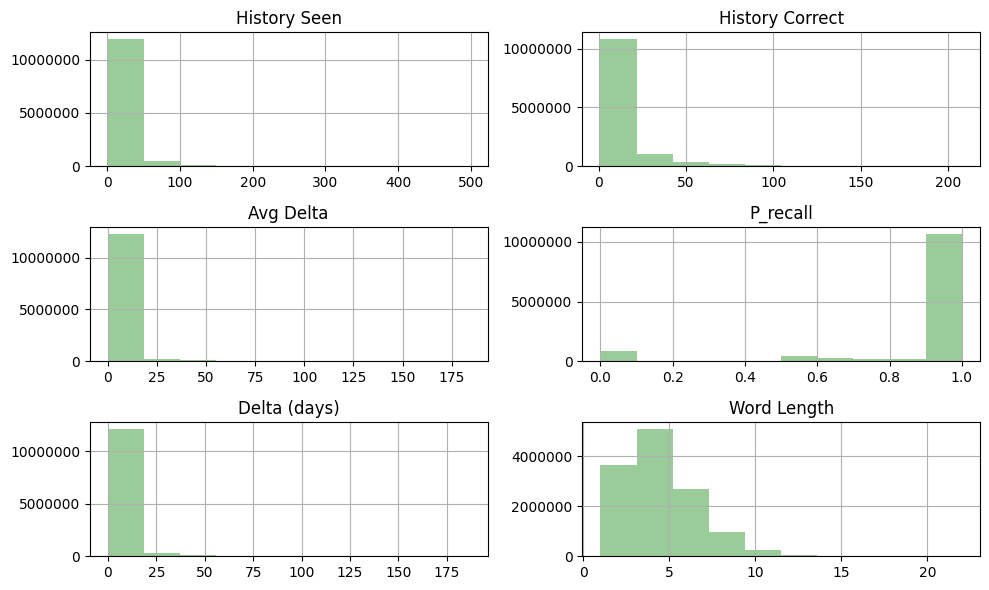

In [187]:

def hclip(h):
    return h.clip(15.0 / (24 * 60), 274.0)

df['std_delta'] = df.groupby(['user_id', 'lang_combination'])['delta'].transform('std')
df['avg_delta'] = df.groupby(['user_id', 'lang_combination'])['delta'].transform('mean')
df['half_life'] = hclip(-df['delta']/np.log2(df['p_recall']))



df['Delta (days)'] = df['delta']/(60*60*60)
df['Avg Delta (days)'] = df['avg_delta']/(60*60*60)


features = ['history_seen', 'history_correct', 'Avg Delta (days)', 'p_recall', 'Delta (days)', 'word_len']
titles = ['History Seen', 'History Correct', 'Avg Delta', 'P_recall', 'Delta (days)', 'Word Length']


axes = df[features].hist(figsize=(10,6), color='g', alpha=0.4)
for ax, title in zip(axes.flatten(), titles):
    ax.ticklabel_format(style='plain')
    ax.set_title(title)
plt.tight_layout()

plt.savefig(out_filepath('histograms_distributions.png'))
plt.show()


The histograms further deepen the knowledge gained based on the boxplots. Most feautures are skewed, with only length of the word resemble normal distirbution. 

In [139]:
### Histograms after transformations of variables

In [182]:
df_2.head()

,p_recall,delta,user_id,learning_language,ui_language,lexeme_id,history_seen,history_correct,session_seen,session_correct,...,POS,person,number,word,word_len,tags_list,SUBTLEX,avg_delta,std_delta,avg_h_recall
0,1.0,27649635,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,6,4,2,2,...,vblex,p3,sg,lernt,5,"['vblex', 'pri', 'p3', 'sg']",3391.0,6.245869e+06,1.175043e+07,0.884367
1,0.5,27649635,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,4,4,2,1,...,det,NaN,sg,die,3,"['det', 'def', 'f', 'sg']",2484854.0,6.245869e+06,1.175043e+07,0.884367
2,1.0,27649635,u:FO,de,en,35a54c25a2cda8127343f6a82e6f6b7d,5,4,1,1,...,n,NaN,sg,mann,4,"['n', 'm', 'sg']",222707.0,6.245869e+06,1.175043e+07,0.884367
3,0.5,27649635,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,6,5,2,1,...,n,NaN,sg,frau,4,"['n', 'f', 'sg']",143725.0,6.245869e+06,1.175043e+07,0.884367
4,1.0,27649635,u:FO,de,en,84920990d78044db53c1b012f5bf9ab5,4,4,1,1,...,det,NaN,sg,das,3,"['det', 'def', 'nt', 'sg']",3122198.0,6.245869e+06,1.175043e+07,0.884367


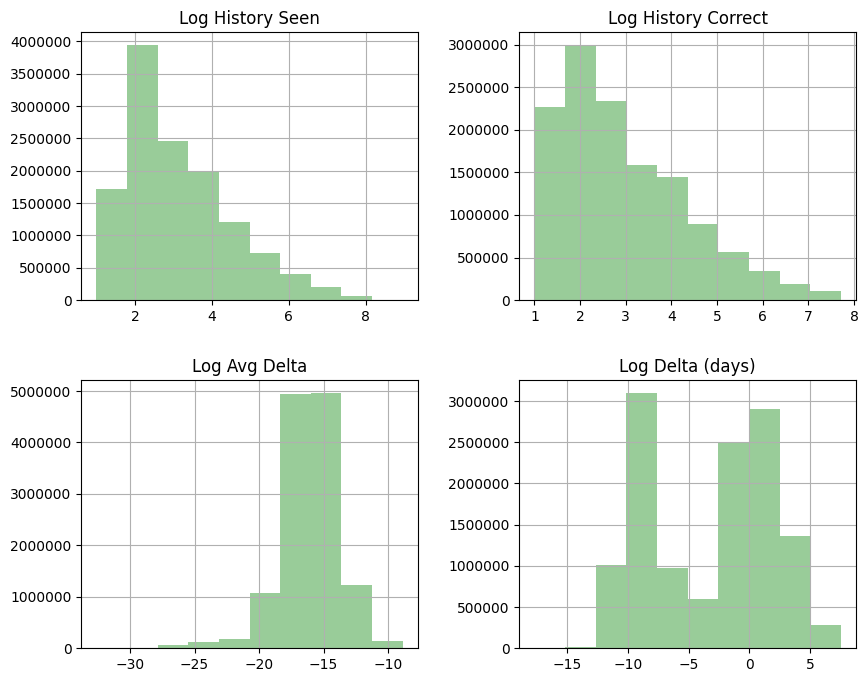

In [176]:


df['log_delta'] = np.log2(df['Delta (days)'])
df['log_avg_delta'] = np.log2(df['Avg Delta (days)']/(60*60*24)+1e-10)
df['p_recall'] = np.log2(1+df['p_recall'])
df['log_history_seen'] = np.log2((1+df['history_seen']))
df['log_history_correct'] = np.log2(1+df['history_correct'])


features = ['log_history_seen', 'log_history_correct', 'log_avg_delta', 'log_delta']
titles = ['Log History Seen', 'Log History Correct', 'Log Avg Delta', 'Log Delta (days)']

axes = df[features].hist(figsize=(10,8), color='g', alpha=0.4)


for ax, title in zip(axes.flatten(), titles):
    ax.ticklabel_format(style='plain')
    ax.set_title(title)
# plt.tight_layout

plt.savefig(out_filepath('histogram_transformations.png'))

### Boxplots one by one by language combination

In [ ]:
for feature, title in zip(features, titles):
    plt.figure(figsize=(7, 3))
    sns.boxplot(x="lang_combination", y=feature, data=df, palette = 'hls')
    plt.title(f'Distribution of {title} by language learning')
    plt.xlabel('')
    plt.ylabel('')
    plt.savefig(out_filepath(f'distribution_{title}.png'))
    plt.show()




The boxplots were divided based on the learning languages, to investigate whether they show any differences. 
For historical recall only French is different from the rest, having median around 0.95 (compared to 1 for the rest). For French also the lower whisker is longer, which suggests the French language is characterized by bigger difficulty. 
The length of the word differs between languages. Spanish has the biggest IQR, which suggests the range of the words is more vast. 
For both English and Spanish the median length is lower than for the rest of languages.

For delta (days) Spanish has the biggest IQR which suggest people have bigger gaps between sessions, than compared got English. 


### Relationship between variables - scatterplot

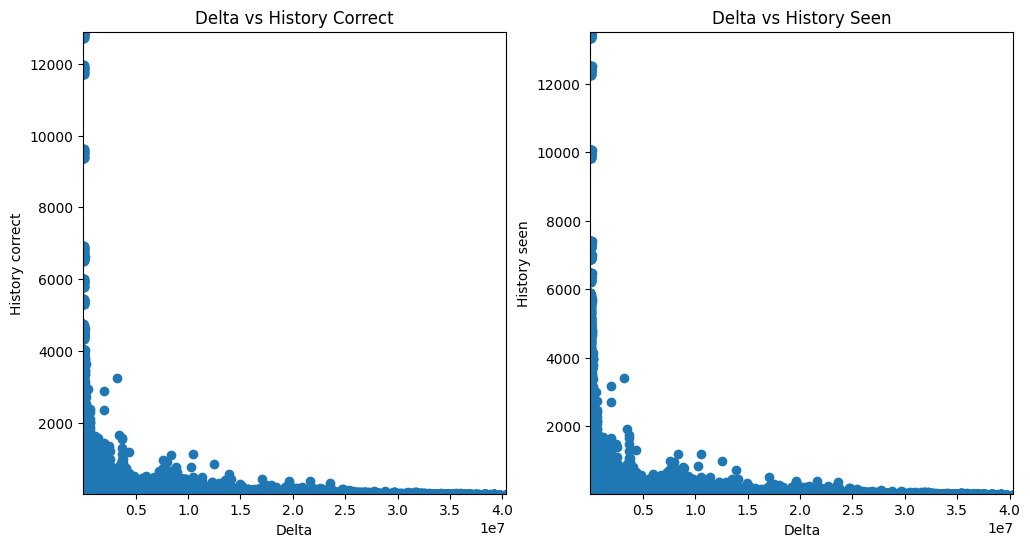

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(df['delta'], df['history_correct'])
axs[0].set_xlabel('Delta')
axs[0].set_ylabel('History correct')
axs[0].set_title('Delta vs History Correct')
axs[0].set_ylim([30, df['history_correct'].max()+1])
axs[0].set_xlim([0.5, df['delta'].max()+1])


axs[1].scatter(df['delta'], df['history_seen'])
axs[1].set_xlabel('Delta')
axs[1].set_ylabel('History seen')
axs[1].set_ylim([30, df['history_seen'].max()+1])
axs[1].set_xlim([0.5, df['delta'].max()+1])

axs[1].set_title('Delta vs History Seen')
plt.savefig(out_filepath('scatterplots_delta.png'))
plt.show()


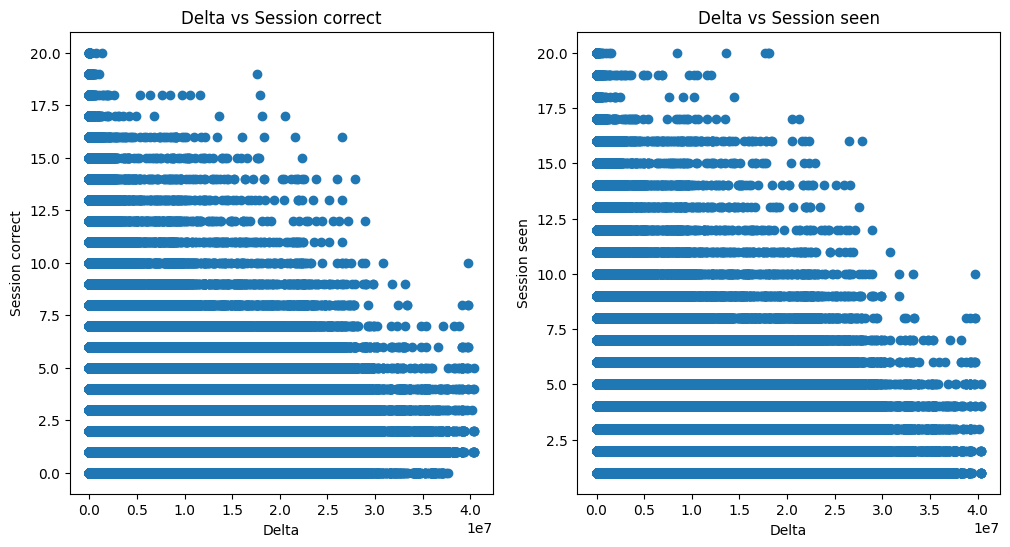

In [167]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(df['delta'], df['session_correct'])
axs[0].set_xlabel('Delta')
axs[0].set_ylabel('Session correct')
axs[0].set_title('Delta vs Session correct')
# axs[0].set_ylim([30, df['history_correct'].max()+1])
# axs[0].set_xlim([0.5, df['delta'].max()+1])


axs[1].scatter(df['delta'], df['session_seen'])
axs[1].set_xlabel('Delta')
axs[1].set_ylabel('Session seen')
# axs[1].set_ylim([30, df['session_seen'].max()+1])
# axs[1].set_xlim([0.5, df['delta'].max()+1])

axs[1].set_title('Delta vs Session seen')
# plt.savefig(out_filepath('scatterplots_delta.png'))
plt.show()


### Words difficulty

In [31]:
df_words = df[['learning_language', 'word', 'h_recall']].groupby(['learning_language', 'word']).mean().reset_index().sort_values(by='h_recall')
print(f'The hardest word is {df_words.iloc[0]['word']}')
top50_hardest = df_words.head(50)

The hardest word is nisto


In [32]:
# !pip install squarify
import squarify

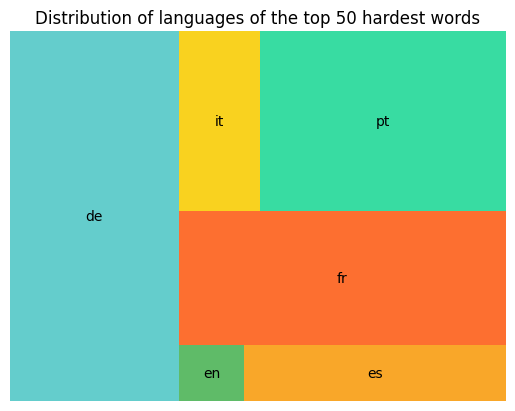

In [36]:
top50_grouped = top50_hardest[['learning_language', 'h_recall']].groupby('learning_language').count().reset_index()

colors = ['#64CDCC', '#5FBB68', '#F9A729', '#FD6F30', '#F9D21F', '#38DCA2']

squarify.plot(sizes = top50_grouped['h_recall'], label = top50_grouped['learning_language'], color=colors)
plt.title('Distribution of languages of the top 50 hardest words')
plt.axis("off")
plt.show()


Within 50 most difficult words (with the lwoer historical recall), the bigger number of words are German, followed by French. English seems to be having the lowest number of difficult words

### Data Analysis after preprocessing the data

In [188]:
import os
import pandas as pd 
current_dir = os.getcwd()
filename = 'df_processed.csv'
filepath = os.path.normpath(os.path.join(current_dir, '../data/processed/', filename))

chunk_size = 10000
chunks = []

for chunk in pd.read_csv(filepath, chunksize=chunk_size):
    chunk.drop_duplicates(inplace=True)
    chunk.dropna(inplace=True)
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
df_users = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'users_behaviur.csv')))
df_words = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'word_complexity_features.csv')), sep='\t')
df_1 = df.merge(df_words, on = 'lexeme_id', how='inner')
df_2 = df_1.merge(df_users, on = ['user_id', 'lang_combination'], how='inner')


In [189]:
df_2.drop(columns=['timestamp', 'h_recall', 'session_seen', 'session_correct'], inplace=True)

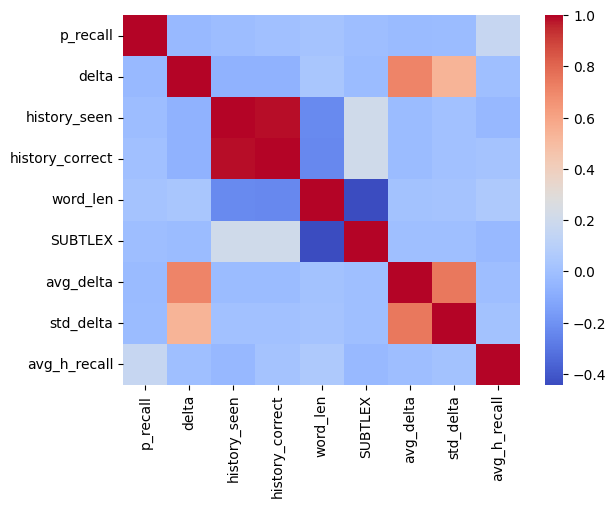

In [190]:
# Correlation between variables
sns_heatmap = sns.heatmap(df_2.select_dtypes(exclude='O').corr(), annot=False, cmap='coolwarm') 
sns_heatmap.figure.savefig(out_filepath('heatmap.png'), bbox_inches='tight')


In [ ]:
# Additional visualizations

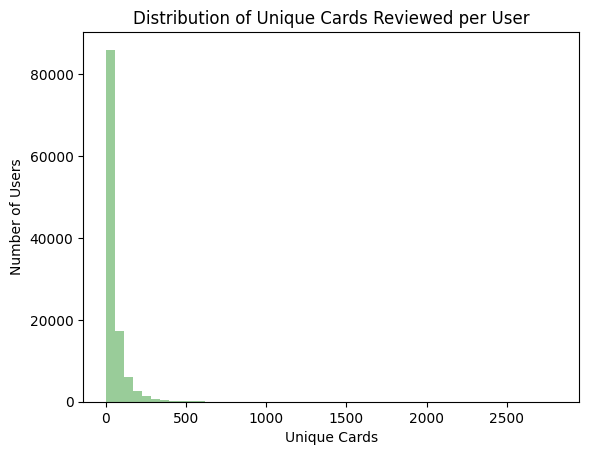

In [54]:
cards_per_user = df_2.groupby('user_id')['word'].nunique()
plt.hist(cards_per_user, bins=50, color='g', alpha=0.4)
plt.title("Distribution of Unique Cards Reviewed per User")
plt.xlabel("Unique Cards")
plt.ylabel("Number of Users")
plt.show()

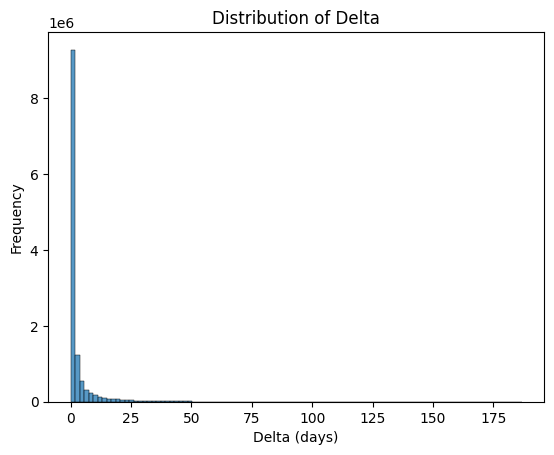

In [68]:
sns.histplot(df['Delta (days)'], bins=100)
plt.title("Distribution of Delta")
plt.xlabel("Delta (days)")
plt.ylabel("Frequency")
plt.savefig(out_filepath('hist_delta_log.png'))
plt.show()

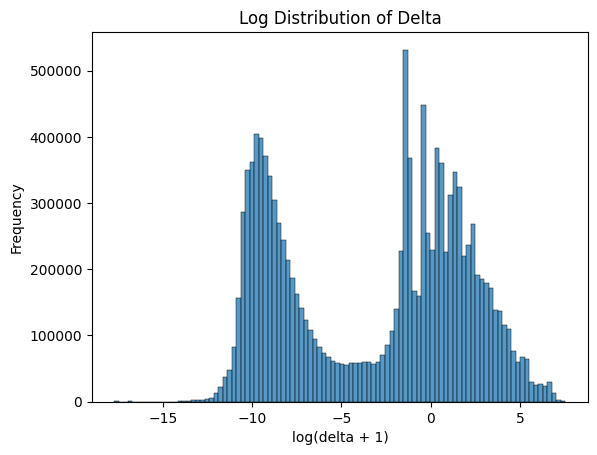

In [70]:
sns.histplot(np.log2(df['Delta (days)']), bins=100)
plt.title("Log Distribution of Delta")
plt.xlabel("log(delta + 1)")
plt.ylabel("Frequency")
plt.savefig(out_filepath('hist_delta_log.png'))
plt.show()

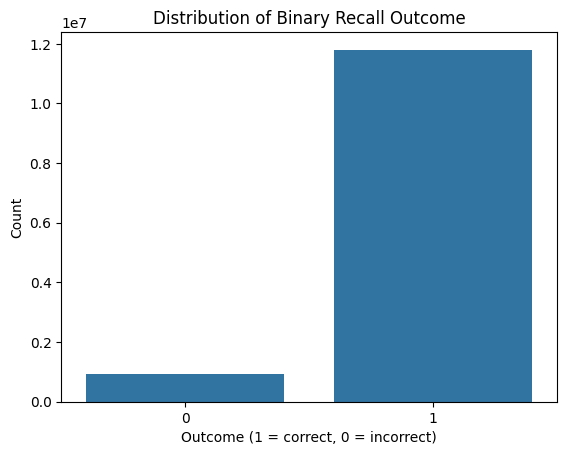

In [71]:
df['outcome'] = (df['p_recall'] >= 0.5).astype(int)
sns.countplot(x='outcome', data=df)
plt.title("Distribution of Binary Recall Outcome")
plt.xlabel("Outcome (1 = correct, 0 = incorrect)")
plt.ylabel("Count")
plt.show()

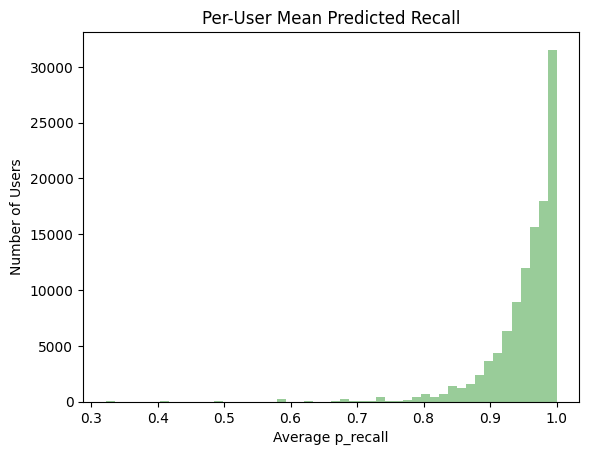

In [145]:
user_avg_recall = df.groupby('user_id')['p_recall'].mean()
plt.hist(user_avg_recall, bins=50, color='g', alpha=0.4)
plt.title("Per-User Mean Predicted Recall")
plt.xlabel("Average p_recall")
plt.ylabel("Number of Users")
plt.savefig(out_filepath('user_mean_recall'), bbox_inches='tight')
plt.show()

In [146]:
df['Delta (days)'].sort_values()

5699867      0.000005
10002769     0.000005
10002770     0.000005
10002771     0.000005
10002772     0.000005
              ...    
11946274    34.577801
12357516    34.577819
11277010    34.578157
12401079    34.578690
11451373    34.578856
Name: Delta (days), Length: 11087193, dtype: float64

/var/folders/_b/l_819g5924d_y00npn9gt60h0000gn/T/ipykernel_25104/1621893556.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg = df_decay.groupby('delta_bin')['p_recall'].mean()


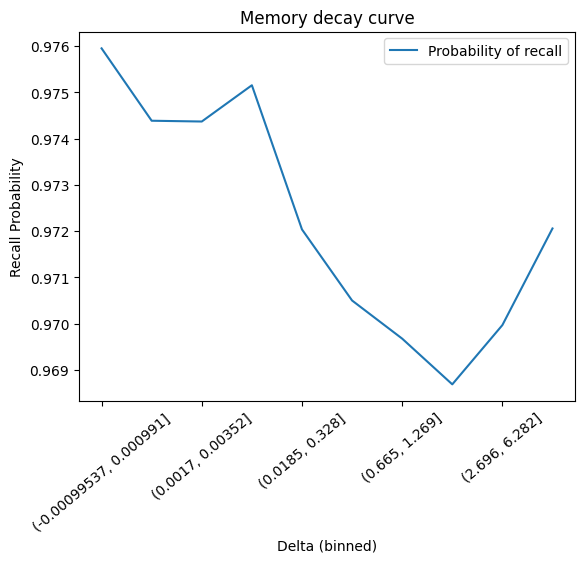

In [147]:
df_decay = df[['Delta (days)', 'p_recall', 'h_recall']].copy()
df_decay['delta_bin'] = pd.qcut(df_decay['Delta (days)'], 10, duplicates='drop')
avg = df_decay.groupby('delta_bin')['p_recall'].mean()

avg.plot()
plt.title("Memory decay curve")
plt.xticks(rotation=40)

plt.xlabel("Delta (binned)")
plt.ylabel("Recall Probability")
plt.legend(['Probability of recall'])
plt.savefig(out_filepath('memory_decay_curve.png'), bbox_inches='tight')
plt.show()

In [46]:
df_users

,user_id,lang_combination,avg_user_p_recall,avg_delta,std_delta,avg_h_recall
0,u:dDwF,en-es,0.885194,2.475405e+06,2.879771e+06,0.954897
1,u:FO,en-de,0.614120,3.104417e+03,2.977079e+03,0.890225
2,u:g3WM,en-pt,0.873737,4.993274e+05,6.501751e+05,0.875062
3,u:dwbJ,pt-en,0.917643,1.298170e+06,1.902581e+06,0.921389
4,u:fxGh,en-es,0.919753,1.132953e+06,1.391952e+06,0.916034
...,...,...,...,...,...,...
115710,u:figN,en-es,0.857143,1.665690e+06,9.697722e+05,0.915454
115711,u:btDs,en-es,0.916667,1.271060e+05,0.000000e+00,0.805556
115712,u:f_W4,pt-en,0.885714,3.527883e+06,1.551145e+06,0.876156
115713,u:i8m1,es-en,0.910714,3.488540e+05,0.000000e+00,0.879592


In [52]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

user_stats = df.copy().select_dtypes(exclude='O')
# user_stats = df_users.drop(columns=['lang_combination'])
user_stats.dropna(inplace=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_stats.iloc[:, 1:])  # Normalize the features


# PCA 
from sklearn.decomposition import PCA
pca_2 = PCA(3)
pca_2_result = pca_2.fit_transform(X_scaled)

print ('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))

Cumulative variance explained by 2 principal components: 71.24%


In [53]:

# Get the feature contributions (loadings)
pca_components_df = pd.DataFrame(pca_2.components_, columns=user_stats.columns[1:])  # Skip first column if it's an index
print("PCA Component Loadings:\n", pca_components_df)


PCA Component Loadings:
    timestamp     delta  history_seen  history_correct  session_seen  \
0  -0.011427 -0.120113      0.700794         0.700762      0.040250   
1   0.014337 -0.040549     -0.044018        -0.043954      0.704308   
2   0.649608  0.605024      0.045819         0.066032      0.027514   

   session_correct  h_recall  
0         0.040471 -0.002175  
1         0.703351 -0.059401  
2         0.039152  0.450782  


100%|█████████████████████████████████████████████| 8/8 [04:39<00:00, 34.95s/it]


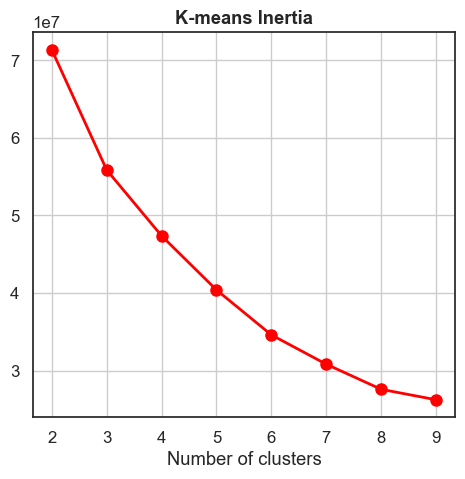

In [54]:
# K-Means 
import sklearn.cluster as cluster
from tqdm import tqdm

inertia = []
for i in tqdm(range(2,10)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    
kmeans = KMeans(n_clusters=3, random_state=42)
user_stats['cluster'] = kmeans.fit_predict(X_scaled)

sns.set(style='white',font_scale=1.1, rc={'figure.figsize':(12,5)})
plt.subplot(1, 2, 1)

plt.plot(range(2,len(inertia)+2), inertia, marker='o',lw=2,ms=8,color='red')
plt.xlabel('Number of clusters')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)


In [55]:
kmeans = cluster.KMeans(n_clusters=3,random_state=17,init='k-means++')
kmeans_labels = kmeans.fit_predict(X_scaled)

centroids = kmeans.cluster_centers_
centroids_pca = pca_2.transform(centroids)

pd.Series(kmeans_labels).value_counts()

1    5298413
2    5179972
0    2049173
Name: count, dtype: int64

In [68]:
user_stats['cluster']=kmeans_labels

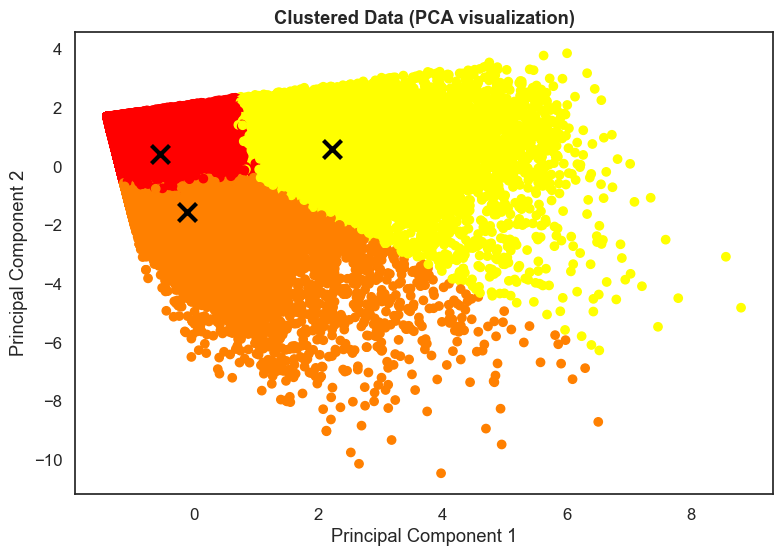

In [70]:
sns.set(style='white', rc={'figure.figsize':(9,6)},font_scale=1.1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], c=kmeans_labels, cmap='autumn')
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
            marker='x', s=169, linewidths=3,
            color='black', zorder=10)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustered Data (PCA visualization)',fontweight='bold')
plt.show()
